#**Understanding the Problem**

This dataset comprises images featuring diverse individuals along with corresponding annotations detailing various body parts. We intend to utilize this dataset in conjunction with another containing information about injuries sustained across different body regions. By integrating these datasets, the resulting model will be capable of accurately identifying injuries depicted in images of individuals.


##Transfer Learning.

Transfer learning is a machine learning technique where knowledge gained from training one model is applied to a different but related problem or domain. In transfer learning, a pre-trained model, which has been trained on a large dataset for a specific task, is used as the starting point for training a new model for a different task.

Here's how it generally works:

1. **Pre-trained Model**: A model is trained on a large dataset for a specific task, such as image classification or natural language processing. This model learns to recognize patterns and features relevant to that task.

2. **Transfer**: Instead of starting the training of a new model from scratch, the pre-trained model's knowledge is transferred to a new model, usually by using its learned parameters (weights and biases) as the initial configuration for the new model.

3. **Fine-tuning**: The new model is then trained on a smaller dataset relevant to the new task. This process fine-tunes the pre-trained model's parameters to better fit the new task, while still retaining the knowledge gained from the original task.

Transfer learning offers several advantages:

- **Reduced Training Time**: Since the new model starts with pre-learned parameters, it often requires fewer training iterations to achieve good performance compared to training from scratch.
- **Less Data Requirement**: Transfer learning is particularly useful when you have a limited amount of data for the new task. The pre-trained model already has learned features that can be generalized to the new task.
- **Better Performance**: By leveraging knowledge from related tasks, transfer learning often results in models that perform better on the new task than if trained from scratch.

Overall, transfer learning is a powerful technique for leveraging the knowledge gained from large datasets and previous tasks to improve performance on new and related tasks.


To address our challenge, we'll implement transfer learning by leveraging pre-trained YOLOv8 weights to refine and train our new model.

In [ ]:
import cv2
import PIL
import glob
import time
import scipy
import random
import pathlib
import warnings
import os,shutil
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import ndimage
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras import layers
from skimage import io, color, feature
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from skimage.feature import graycomatrix, graycoprops
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, LeakyReLU, BatchNormalization, Activation
warnings.filterwarnings("ignore")

###Data Exploration

These are some of the things we will need to explore about our dataset:


1. **Dimensionality Analysis**: Examine the dimensions of the images in the dataset, such as height, width, and color channels. Understanding the size and shape of the images can help in preprocessing and model design.

2. **Image Visualization**: Display a random sample of images from the dataset to visually inspect the data. This can help identify patterns, anomalies, or any preprocessing requirements.

3. **Distribution of Labels**: If the images are labeled, analyze the distribution of labels/classes. Understanding the distribution can help identify class imbalances, which might affect model performance.

4. **Pixel Intensity Distribution**: Plot histograms of pixel intensities across the dataset. This can reveal information about the contrast, brightness, and overall quality of the images.

5. **Image Quality Assessment**: Perform quality assessment checks on images to identify any artifacts, noise, or inconsistencies that may affect model performance. This could involve techniques like blurriness detection, edge detection, or image compression analysis.

In [ ]:
# Defining the path for train and validation images and the labels
train_image_dir = pathlib.Path("/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/train/images")
val_image_dir = pathlib.Path("/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/valid/images")

train_labels_dir = pathlib.Path('/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/train/labels')
val_labels_dir= pathlib.Path('/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/valid/labels')

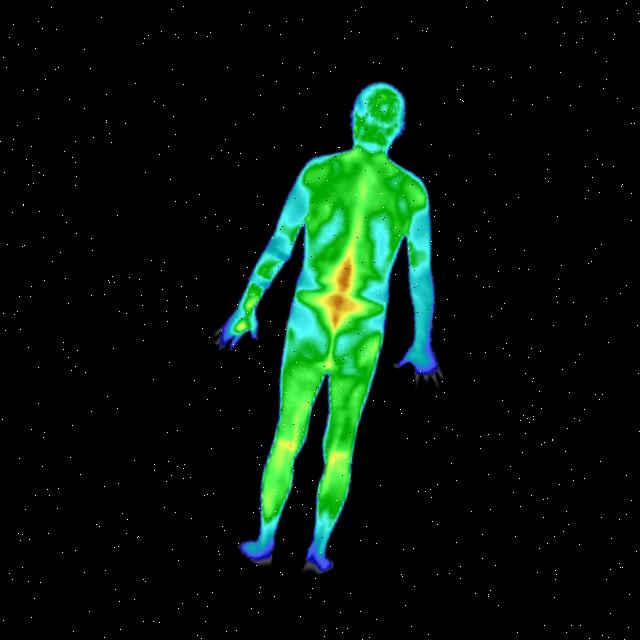

In [ ]:
from google.colab.patches import cv2_imshow

# Path to the image
image_path = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/train/images/caoguangyihongwaitupian_8_585938061796577280_bmp.rf.1b4c6e698d925473bd77756ab12bc0d5.jpg"

# Load the image
sample_image = cv2.imread(image_path)

# Check if the image is successfully loaded
if sample_image is not None:
    # Display the image using cv2_imshow
    cv2_imshow(sample_image)
else:
    print("Failed to load the image.")

In [ ]:
#dimensionality analysis
train_image_dir = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/train/images"

# Function to analyze dimensions of images
def analyze_dimensions(image_dir):
    # List all files in the directory
    files = os.listdir(image_dir)

    # Initialize variables to store dimensions statistics
    total_images = len(files)
    total_height = 0
    total_width = 0
    total_channels = 0

    # Analyze dimensions for each image
    for file in files:
        # Construct the path to the image
        image_path = os.path.join(image_dir, file)

        # Load the image
        image = cv2.imread(image_path)

        # Add dimensions to totals
        total_height += image.shape[0]
        total_width += image.shape[1]
        total_channels += image.shape[2]

    # Calculate average dimensions
    average_height = total_height / total_images
    average_width = total_width / total_images
    average_channels = total_channels / total_images

    # Print analysis
    print("Dimensionality Analysis:")
    print(f"Total Images: {total_images}")
    print(f"Average Height: {average_height}")
    print(f"Average Width: {average_width}")
    print(f"Average Channels: {average_channels}")

# Perform Dimensionality Analysis
analyze_dimensions(train_image_dir)


Dimensionality Analysis:
Total Images: 318
Average Height: 640.0
Average Width: 640.0
Average Channels: 3.0


The image dimensions (640x640) indicate that the image has a height of 640 pixels and a width of 640 pixels. The tuple (640, 640, 3) indicates that the image has three channels, which suggests it's in RGB (Red, Green, Blue) color format. Each pixel in the image is represented by three values corresponding to the intensity of red, green, and blue light, respectively.

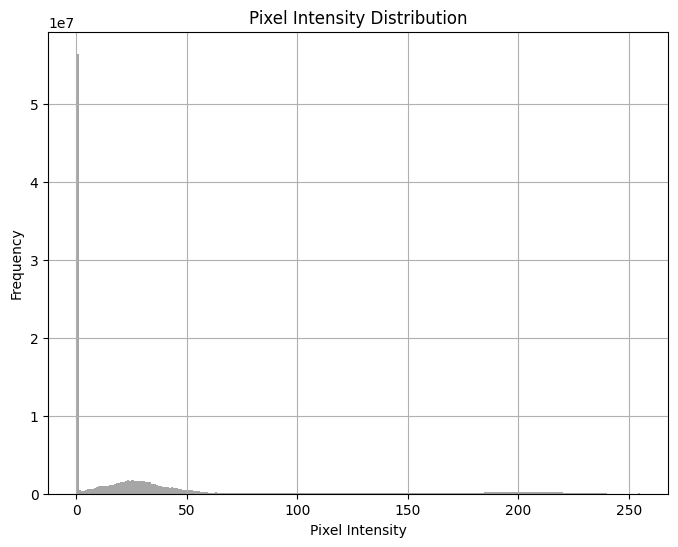

In [ ]:
#pixel intensity distribution
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt



# Function to read and convert images to grayscale
def read_and_convert_to_gray(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

# Iterate through images, read, and convert to grayscale
pixel_intensities = []
for filename in os.listdir(train_image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(train_image_dir, filename)
        grayscale_image = read_and_convert_to_gray(image_path)
        pixel_intensities.extend(grayscale_image.flatten())

# Convert pixel intensities list to NumPy array
pixel_intensities = np.array(pixel_intensities)

# Plot histogram of pixel intensities
plt.figure(figsize=(8, 6))
plt.hist(pixel_intensities, bins=256, color='gray', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
#analysis on the types of labels used and the number of times each has been used
# Function to load label names from the YAML file
def load_label_names(yaml_file):
    with open(yaml_file, 'r') as file:
        data = yaml.safe_load(file)
    return data['names']

# Path to the directory containing labeled images
label_dir = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/train/labels"

# Path to the YAML file containing label names
yaml_file = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/data.yaml"

# Load label names from the YAML file
label_names = load_label_names(yaml_file)

# Initialize an empty dictionary to store label counts
label_counts = {label_name: 0 for label_name in label_names}

# Iterate through labeled images and extract labels
for filename in os.listdir(label_dir):
    if filename.endswith(".txt"):
        label_file_path = os.path.join(label_dir, filename)
        with open(label_file_path, 'r') as file:
            for line in file:
                label_index = int(line.strip().split()[0])  # Assuming the label index is the first value
                label_name = label_names[label_index]  # Map label index to label name using the YAML file
                label_counts[label_name] += 1

# Print label counts
for label_name, count in label_counts.items():
    print(f"{label_name}: {count}")

bm_arm_left: 318
bm_arm_right: 318
bm_body_up: 318
bm_hand_left: 318
bm_hand_right: 318
bm_head: 318
bm_leftfoot: 318
bm_leftknee: 318
bm_leftleg: 318
bm_leftsleg: 318
bm_neck: 318
bm_rightfoot: 318
bm_rightknee: 318
bm_rightleg: 318
bm_rightsleg: 318
bm_sarm_left: 318
bm_sarm_right: 318


There are 17 labels and each has been used equal number of times

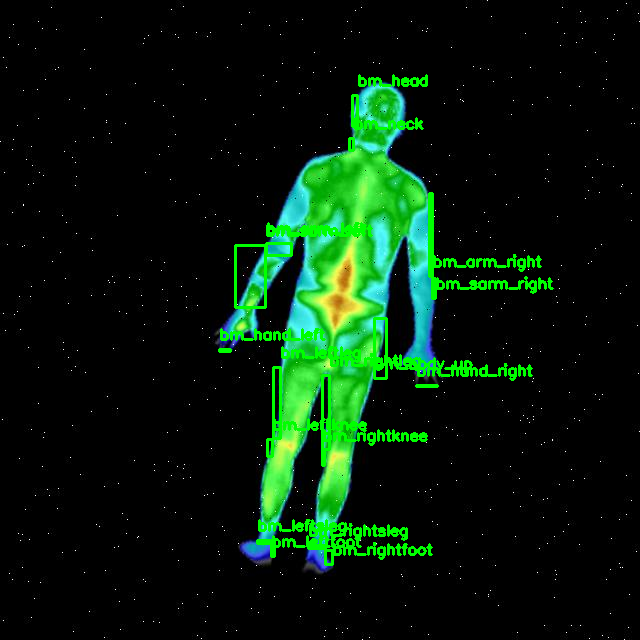

In [ ]:
import cv2
import os
import yaml
from google.colab.patches import cv2_imshow

# Function to load label names from the YAML file
def load_label_names(yaml_file):
    with open(yaml_file, 'r') as file:
        data = yaml.safe_load(file)
    return data['names']

# Path to the directory containing images
image_dir = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/train/images"

# Name of the image file
image_file_name = "caoguangyihongwaitupian_8_585938061796577280_bmp.rf.1b4c6e698d925473bd77756ab12bc0d5.jpg"

# Construct the path to the image
image_path = os.path.join(image_dir, image_file_name)

# Load the image
sample_image = cv2.imread(image_path)

# Path to the directory containing label text files
labels_dir = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/train/labels"

# Name of the label text file (same as image file name but with .txt extension)
label_file_name = os.path.splitext(image_file_name)[0] + ".txt"

# Construct the path to the label text file
label_file_path = os.path.join(labels_dir, label_file_name)

# Check if the label file exists
if os.path.exists(label_file_path):
    # Read bounding box annotations from the label file
    with open(label_file_path, 'r') as file:
        lines = file.readlines()
    annotations = []
    for line in lines:
        line = line.strip().split()
        class_index = int(line[0])  # Assuming the first value is the class index
        # Extracting bounding box coordinates (x_min, y_min, x_max, y_max)
        x_min = float(line[1])
        y_min = float(line[2])
        x_max = float(line[3])
        y_max = float(line[4])
        annotations.append([class_index, x_min, y_min, x_max, y_max])

    # Path to the YAML file containing label names
    yaml_file = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/data.yaml"

    # Load label names from the YAML file
    label_names = load_label_names(yaml_file)

    # Draw bounding boxes on the image
    for annotation in annotations:
        class_index, x_min, y_min, x_max, y_max = annotation
        # Drawing the bounding box
        x_min = int(x_min * sample_image.shape[1])
        y_min = int(y_min * sample_image.shape[0])
        x_max = int(x_max * sample_image.shape[1])
        y_max = int(y_max * sample_image.shape[0])
        label_name = label_names[class_index]
        cv2.rectangle(sample_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(sample_image, label_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image with annotations
    cv2_imshow(sample_image)
else:
    print(f"Label file '{label_file_path}' does not exist.")

In [ ]:
#let's get to know the types of image files in the train folder and the count of each
train_image_dir = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/train/images"

# List all files in the directory
files = os.listdir(train_image_dir)

# Extract file extensions and count their occurrences
file_extensions = {}
for file in files:
    # Split the filename and extension
    _, extension = os.path.splitext(file)
    # Increment the count for this extension
    file_extensions[extension] = file_extensions.get(extension, 0) + 1

# Print the types of image files
print("Types of image files stored in the images folder for the train folder:")
for extension, count in file_extensions.items():
    print(f"{extension}: {count} file(s)")

Types of image files stored in the images folder for the train folder:
.jpg: 318 file(s)


In [ ]:
#let's get to know the types of label files in the train folder and the count of each
train_labels_dir = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/train/labels"

# List all files in the directory
files = os.listdir(train_labels_dir)

# Extract file extensions and count their occurrences
file_extensions = {}
for file in files:
    # Split the filename and extension
    _, extension = os.path.splitext(file)
    # Increment the count for this extension
    file_extensions[extension] = file_extensions.get(extension, 0) + 1

# Print the types of image files
print("Types of label files stored in the images folder for the train folder:")
for extension, count in file_extensions.items():
    print(f"{extension}: {count} file(s)")

Types of label files stored in the images folder for the train folder:
.txt: 318 file(s)


We can infer that the train folder contains a total of 318 image files, each of which has an associated label file, resulting in a corresponding count of 318 label files.

In [ ]:
#let's explore the validation folder too
val_image_dir = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/valid/images"

# List all files in the directory
files = os.listdir(val_image_dir)

# Extract file extensions and count their occurrences
file_extensions = {}
for file in files:
    # Split the filename and extension
    _, extension = os.path.splitext(file)
    # Increment the count for this extension
    file_extensions[extension] = file_extensions.get(extension, 0) + 1

# Print the types of image files
print("Types of image files stored in the images folder for the validation folder:")
for extension, count in file_extensions.items():
    print(f"{extension}: {count} file(s)")

Types of image files stored in the images folder for the validation folder:
.jpg: 30 file(s)


In [ ]:
#let's get to know the types of label files in the validation folder and the count of each
val_labels_dir = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/valid/labels"

# List all files in the directory
files = os.listdir(val_labels_dir)

# Extract file extensions and count their occurrences
file_extensions = {}
for file in files:
    # Split the filename and extension
    _, extension = os.path.splitext(file)
    # Increment the count for this extension
    file_extensions[extension] = file_extensions.get(extension, 0) + 1

# Print the types of image files
print("Types of label files stored in the images folder for the validation folder:")
for extension, count in file_extensions.items():
    print(f"{extension}: {count} file(s)")

Types of label files stored in the images folder for the validation folder:
.txt: 30 file(s)


#Modeling

##a) Using YOLOv8

In [ ]:
#instaling the various packages
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.3/760.3 kB 8.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install Pillow

In [ ]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image

**Import a model and populate it with pre-trained weights.**

Here, we will import an instance segmentation model with weights.

In [ ]:
#instance
model = YOLO('yolov8n-seg.yaml') #build a new model from YAML
model = YOLO('yolov8n-seg.pt') #transfer the weights from a pre-trained model

100%|██████████| 6.73M/6.73M [00:00<00:00, 106MB/s]


Let us load the YAML file that contains the names of our classes, number of classes and the directories of train, valid, and test datasets respectively

In [ ]:
#load the YAML file to the notebook
%cat /content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/data.yaml

train: /content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/train/images
val: /content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/valid/images
test: /content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/test/images

nc: 17
names: ['bm_arm_left', 'bm_arm_right', 'bm_body_up', 'bm_hand_left', 'bm_hand_right', 'bm_head', 'bm_leftfoot', 'bm_leftknee', 'bm_leftleg', 'bm_leftsleg', 'bm_neck', 'bm_rightfoot', 'bm_rightknee', 'bm_rightleg', 'bm_rightsleg', 'bm_sarm_left', 'bm_sarm_right']

roboflow:
  workspace: irtzm
  project: person_part_seg_bm
  version: 5
  license: CC BY 4.0
  url: https://universe.roboflow.com/irtzm/person_part_seg_bm/dataset/5

In [ ]:
#define the number of classes based on YAML
import yaml
with open ('/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/data.yaml', 'r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])
  print('The number of classes is:', num_classes)

The number of classes is: 17


##Train the model.

In [ ]:
#define a directory to store the results
project = '/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/results'

#define a sub-directory for this specific training
name= '250 epochs'

In [ ]:
#train the model
results = model.train(data = '/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/data.yaml',
                      project=project,
                      name=name,
                      epochs=250,
                      patience=0, #we disable early stopping so the model can train on all 1500 epochs
                      batch=4,
                      imgsz=640)

Ultralytics YOLOv8.2.20 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/data.yaml, epochs=250, time=None, patience=0, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/results, name=250 epochs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, re

100%|██████████| 755k/755k [00:00<00:00, 20.8MB/s]


Overriding model.yaml nc=80 with nc=17

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 6.23M/6.23M [00:00<00:00, 99.0MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/train/labels.cache... 318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 318/318 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/valid/labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/results/250 epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000476, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/results/250 epochs
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      1/250      1.38G      2.023      3.057      4.634      1.592         74        640: 100%|██████████| 80/80 [00:40<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered in

                   all         30        510      0.984      0.051     0.0582      0.039      0.984      0.051     0.0579     0.0418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/250      1.68G      1.522      1.984      3.481      1.155         81        640: 100%|██████████| 80/80 [00:29<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all         30        510      0.591      0.322       0.34      0.223      0.591      0.322      0.337      0.221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/250      1.79G      1.407       1.74      2.488      1.113         38        640: 100%|██████████| 80/80 [00:30<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

                   all         30        510      0.492      0.672      0.535      0.341      0.494      0.676       0.55      0.341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/250      1.65G      1.342      1.611      1.893      1.088         64        640: 100%|██████████| 80/80 [00:29<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all         30        510      0.552      0.797      0.629      0.393      0.551      0.799       0.63      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/250      1.73G      1.279      1.557      1.671      1.061         28        640: 100%|██████████| 80/80 [00:29<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

                   all         30        510       0.55      0.879       0.67      0.445      0.548      0.876      0.668       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/250      1.55G      1.194      1.462      1.454      1.033         84        640: 100%|██████████| 80/80 [00:30<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all         30        510      0.573      0.917      0.699       0.47      0.566      0.908      0.691      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/250      1.75G      1.155      1.444      1.374      1.027         27        640: 100%|██████████| 80/80 [00:28<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


                   all         30        510      0.577      0.936      0.698      0.451      0.573      0.921       0.69      0.461

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/250      1.67G      1.115      1.387      1.306      1.004         49        640: 100%|██████████| 80/80 [00:30<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

                   all         30        510      0.586      0.918      0.722      0.487      0.583      0.915      0.722      0.488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/250      1.81G      1.102      1.359      1.272      1.006         23        640: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]

                   all         30        510      0.587      0.947      0.736      0.491      0.582       0.94       0.73      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/250      1.55G      1.053      1.324      1.225     0.9788         84        640: 100%|██████████| 80/80 [00:31<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.47it/s]

                   all         30        510      0.581      0.981      0.736      0.502      0.578      0.974       0.73      0.496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/250      1.71G       1.04       1.28      1.202     0.9796         39        640: 100%|██████████| 80/80 [00:28<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

                   all         30        510      0.588      0.985      0.696      0.483      0.581      0.973      0.688      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/250      1.53G      1.011      1.262      1.171     0.9741         68        640: 100%|██████████| 80/80 [00:31<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

                   all         30        510      0.589      0.954      0.729      0.502      0.589      0.957      0.733      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/250      1.53G      1.019       1.27      1.169     0.9775         35        640: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all         30        510      0.676      0.874      0.808      0.562       0.67      0.869      0.805      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/250      1.67G       1.02      1.269      1.133     0.9789         35        640: 100%|██████████| 80/80 [00:30<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


                   all         30        510      0.603      0.949      0.783      0.555      0.603      0.939      0.779      0.553

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/250      1.41G     0.9905      1.239      1.113     0.9607         25        640: 100%|██████████| 80/80 [00:28<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all         30        510      0.629      0.958      0.811      0.564      0.634      0.942      0.808      0.569



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/250      1.75G     0.9934      1.198      1.102     0.9607         52        640: 100%|██████████| 80/80 [00:29<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]

                   all         30        510      0.639      0.929      0.776      0.538      0.637      0.923      0.773      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/250      1.74G      1.001      1.222       1.09     0.9608         40        640: 100%|██████████| 80/80 [00:29<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]

                   all         30        510      0.602      0.965      0.781      0.549      0.601      0.959      0.777      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/250       1.8G      0.986       1.22      1.069     0.9646         96        640: 100%|██████████| 80/80 [00:28<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

                   all         30        510      0.619      0.961      0.777      0.553      0.619      0.961      0.777      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/250      1.81G     0.9921      1.227      1.063      0.959         26        640: 100%|██████████| 80/80 [00:30<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all         30        510      0.613       0.96      0.773      0.546       0.61      0.956      0.771      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/250      1.59G     0.9553      1.192      1.024     0.9585         79        640: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]

                   all         30        510      0.662      0.908      0.837      0.586       0.66      0.907      0.835      0.583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/250       1.8G     0.9633      1.217      1.007     0.9596         59        640: 100%|██████████| 80/80 [00:30<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all         30        510       0.63      0.966      0.796      0.562      0.628      0.964      0.794      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/250      1.64G     0.9469      1.179     0.9942     0.9511         39        640: 100%|██████████| 80/80 [00:28<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.65it/s]


                   all         30        510      0.722      0.913      0.873      0.623       0.72       0.91       0.87      0.614

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/250      1.68G     0.9524      1.191     0.9705     0.9496         43        640: 100%|██████████| 80/80 [00:30<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all         30        510      0.605      0.962      0.751      0.536      0.605      0.962      0.751       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/250      1.74G     0.9543      1.175     0.9645     0.9445         38        640: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

                   all         30        510      0.725      0.912      0.884      0.637      0.709      0.893      0.868      0.614



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/250      1.47G     0.9326      1.152     0.9238     0.9444         41        640: 100%|██████████| 80/80 [00:30<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


                   all         30        510      0.656      0.952      0.824      0.593      0.652      0.948      0.822       0.59

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/250      1.72G     0.9197       1.13     0.8828      0.941         50        640: 100%|██████████| 80/80 [00:27<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


                   all         30        510      0.745      0.904      0.875       0.62      0.742        0.9      0.871      0.615

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/250      1.52G     0.9219      1.113     0.8825     0.9372         59        640: 100%|██████████| 80/80 [00:30<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.03it/s]

                   all         30        510      0.719      0.915      0.869      0.628      0.714       0.91      0.862      0.617



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/250       1.5G     0.9094      1.133     0.8442     0.9394         53        640: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all         30        510      0.705      0.918      0.846      0.601      0.704       0.91      0.838       0.59



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/250      1.59G     0.9324       1.15     0.8348     0.9416         26        640: 100%|██████████| 80/80 [00:29<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]

                   all         30        510      0.859      0.872      0.937      0.667      0.853      0.867      0.927      0.658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/250       1.6G     0.8919      1.118     0.8054     0.9373         38        640: 100%|██████████| 80/80 [00:28<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all         30        510      0.701      0.909      0.875      0.624      0.694      0.901      0.867      0.612



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/250      1.57G     0.8883      1.113     0.7829     0.9377         30        640: 100%|██████████| 80/80 [00:28<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


                   all         30        510      0.823      0.885      0.924      0.665      0.811      0.874      0.909      0.638

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/250      1.64G     0.9037      1.134     0.7703     0.9369         44        640: 100%|██████████| 80/80 [00:29<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all         30        510       0.77      0.915      0.903      0.643      0.765      0.909      0.895      0.637



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/250      1.81G     0.8887      1.092     0.7545     0.9325         47        640: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

                   all         30        510      0.837      0.914      0.942      0.665      0.832      0.911      0.935      0.665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/250      1.59G     0.8889      1.125     0.7563     0.9325         43        640: 100%|██████████| 80/80 [00:30<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all         30        510      0.923       0.95      0.981      0.695      0.917      0.947      0.976      0.684



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/250      1.86G     0.8895      1.104     0.7409     0.9283         27        640: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.15it/s]

                   all         30        510        0.9      0.928      0.959      0.675      0.901      0.931      0.963      0.681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/250      1.74G     0.8723        1.1     0.7266     0.9284         25        640: 100%|██████████| 80/80 [00:31<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]

                   all         30        510      0.706       0.91      0.857      0.617      0.697      0.901      0.845      0.594



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/250      1.38G     0.8702      1.103     0.7263     0.9315         65        640: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all         30        510      0.871      0.947      0.973      0.678      0.866      0.941      0.966      0.671



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/250      1.88G     0.8605      1.061     0.7153      0.926         18        640: 100%|██████████| 80/80 [00:31<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]

                   all         30        510       0.74      0.889      0.888       0.64      0.737      0.886      0.882      0.624



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/250       1.8G      0.862      1.083     0.7115     0.9279         40        640: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]

                   all         30        510      0.894      0.949      0.976      0.693      0.889      0.943      0.967      0.691



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/250      1.89G     0.8569      1.071     0.6949     0.9217         33        640: 100%|██████████| 80/80 [00:31<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]

                   all         30        510      0.886      0.913      0.954      0.691      0.885      0.913      0.953      0.672



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/250      1.73G       0.85      1.046     0.6792     0.9131         52        640: 100%|██████████| 80/80 [00:28<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all         30        510      0.883      0.929      0.952      0.688      0.881      0.927      0.951      0.658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/250      1.47G     0.8672      1.096     0.6943     0.9276         37        640: 100%|██████████| 80/80 [00:30<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]

                   all         30        510      0.875       0.92      0.954       0.68      0.871      0.916      0.952      0.664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/250      1.56G     0.8517      1.062     0.6734     0.9202         13        640: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all         30        510        0.9      0.954      0.975      0.688      0.885       0.94      0.957      0.651



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/250       1.8G     0.8478      1.061      0.664     0.9174         66        640: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

                   all         30        510       0.92      0.949      0.981      0.704       0.91      0.939      0.971      0.672



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/250      1.39G     0.8491       1.08     0.6572     0.9219         41        640: 100%|██████████| 80/80 [00:29<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all         30        510      0.923      0.962      0.982      0.707      0.917      0.956      0.975      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/250      1.32G      0.829      1.037     0.6407     0.9181         27        640: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all         30        510      0.909      0.936      0.962      0.691      0.897      0.925      0.949      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/250      1.65G     0.8396      1.068     0.6426     0.9163         30        640: 100%|██████████| 80/80 [00:31<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all         30        510       0.92      0.951      0.975      0.694      0.918      0.949      0.969      0.681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/250      1.56G     0.8198       1.04     0.6258     0.9169         71        640: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all         30        510      0.855      0.877      0.941      0.679      0.847       0.87      0.932      0.651



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/250      1.57G     0.8351      1.039     0.6412     0.9162         69        640: 100%|██████████| 80/80 [00:31<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


                   all         30        510      0.931      0.948      0.973      0.711      0.931      0.947      0.973      0.695

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/250      1.92G     0.8273      1.045     0.6247     0.9154         79        640: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


                   all         30        510      0.884      0.907      0.938      0.679      0.878      0.901      0.931      0.655

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/250      1.68G     0.8113      1.015     0.6112     0.9082         41        640: 100%|██████████| 80/80 [00:31<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]

                   all         30        510       0.95       0.95      0.982      0.702      0.946      0.946      0.977      0.683



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/250      1.37G     0.8144      1.015     0.6063     0.9082         49        640: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

                   all         30        510      0.911      0.958       0.98      0.701      0.902      0.948      0.968      0.667



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/250      1.47G     0.8176      1.035     0.6051     0.9098         26        640: 100%|██████████| 80/80 [00:31<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]

                   all         30        510      0.881      0.915       0.95      0.681      0.871      0.905      0.941      0.657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/250      1.57G     0.8079      1.029     0.6089     0.9125         93        640: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


                   all         30        510      0.878      0.915      0.947      0.681      0.879      0.904       0.94      0.658

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/250      1.47G     0.8165      1.012     0.5981     0.9109         84        640: 100%|██████████| 80/80 [00:31<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]

                   all         30        510      0.902       0.94      0.972      0.705      0.887      0.944      0.965      0.688



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/250      1.65G     0.8161      1.012     0.6092      0.907         53        640: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

                   all         30        510      0.877       0.93       0.96      0.696      0.869      0.923      0.949      0.666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/250      1.64G     0.8096      1.038     0.5965     0.9101         73        640: 100%|██████████| 80/80 [00:31<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

                   all         30        510      0.915      0.946      0.967      0.695      0.913      0.944      0.963      0.672



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/250      1.84G     0.7991     0.9957     0.5822      0.905         52        640: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


                   all         30        510       0.91      0.949      0.968      0.703      0.906      0.945      0.965      0.678

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/250      1.82G     0.7959     0.9799     0.5819     0.9027         17        640: 100%|██████████| 80/80 [00:30<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]

                   all         30        510      0.907      0.947      0.975      0.703      0.892       0.94      0.963      0.677



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/250      1.67G     0.8066      1.019     0.5888     0.9102         37        640: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

                   all         30        510      0.907      0.946      0.977      0.708      0.897      0.936      0.964      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/250      1.65G     0.7993     0.9858     0.5686     0.9027         79        640: 100%|██████████| 80/80 [00:30<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all         30        510      0.895      0.924      0.957      0.691      0.888      0.919      0.948      0.661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/250      1.67G     0.7969     0.9816     0.5683     0.9025         59        640: 100%|██████████| 80/80 [00:28<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

                   all         30        510      0.926      0.941      0.966      0.698      0.924      0.939      0.964      0.671



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/250      1.76G     0.8004     0.9975     0.5645     0.8968         58        640: 100%|██████████| 80/80 [00:30<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]

                   all         30        510      0.933      0.962      0.978      0.703      0.931       0.96      0.974      0.692



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/250       1.5G     0.7958     0.9873      0.583     0.9066         26        640: 100%|██████████| 80/80 [00:28<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all         30        510       0.88      0.892      0.938      0.674      0.869       0.88      0.924      0.647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/250      1.46G     0.7889     0.9889     0.5702     0.9044         23        640: 100%|██████████| 80/80 [00:29<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

                   all         30        510      0.905       0.93      0.964      0.693      0.898       0.93      0.962      0.662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/250      1.67G     0.7993      1.004     0.5764     0.9018         75        640: 100%|██████████| 80/80 [00:29<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all         30        510      0.906      0.969      0.972      0.702        0.9      0.963      0.966      0.674



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/250      1.72G     0.7938     0.9933      0.574     0.8998         40        640: 100%|██████████| 80/80 [00:29<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

                   all         30        510      0.869      0.956      0.962      0.696      0.866      0.952      0.957      0.669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/250      1.65G      0.797     0.9944     0.5707     0.9039         41        640: 100%|██████████| 80/80 [00:30<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all         30        510      0.903      0.938      0.968      0.708      0.901      0.936      0.965       0.67



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/250      1.64G     0.7846     0.9766     0.5548     0.8966         36        640: 100%|██████████| 80/80 [00:28<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

                   all         30        510       0.93      0.927      0.973      0.701      0.926      0.924      0.969      0.683



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/250      1.64G     0.7808     0.9743     0.5554     0.9034         36        640: 100%|██████████| 80/80 [00:31<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all         30        510      0.865      0.942       0.96      0.684      0.859      0.937      0.954      0.669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/250      1.56G     0.7756     0.9657      0.551     0.9022         36        640: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all         30        510      0.966      0.963      0.986      0.708      0.958      0.955      0.975      0.684



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/250      1.55G     0.7652     0.9611     0.5437     0.8967         98        640: 100%|██████████| 80/80 [00:31<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


                   all         30        510      0.931      0.933      0.974      0.703      0.925      0.925      0.964      0.673

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/250      1.63G     0.7458     0.9365     0.5352      0.886         83        640: 100%|██████████| 80/80 [00:28<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


                   all         30        510      0.939      0.952      0.972      0.703      0.935      0.948      0.968      0.678

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/250      1.34G     0.7838      0.978     0.5586     0.9006         90        640: 100%|██████████| 80/80 [00:31<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]

                   all         30        510      0.939      0.963      0.983      0.716      0.928      0.953      0.971      0.688



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/250      1.44G     0.7656      0.954     0.5462     0.8956         79        640: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


                   all         30        510      0.932       0.95      0.973      0.706      0.919      0.938      0.962      0.675

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/250      1.75G     0.7772      0.971     0.5487     0.8973         74        640: 100%|██████████| 80/80 [00:32<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


                   all         30        510      0.877      0.909      0.946      0.674      0.871      0.896       0.93      0.647

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/250      1.74G     0.7645     0.9595     0.5497     0.8964         39        640: 100%|██████████| 80/80 [00:28<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all         30        510       0.94      0.974      0.984      0.707      0.928      0.963      0.972      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/250      1.64G     0.7665     0.9511     0.5501     0.8954         99        640: 100%|██████████| 80/80 [00:29<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all         30        510      0.923      0.905      0.967      0.691      0.915      0.897      0.959       0.67



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/250       1.7G     0.7561      0.938     0.5387     0.8935         25        640: 100%|██████████| 80/80 [00:29<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all         30        510      0.859      0.946       0.95      0.682       0.85      0.937      0.939      0.655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/250      1.86G     0.7514     0.9432     0.5298     0.8908         32        640: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all         30        510      0.877      0.911      0.942      0.688      0.871      0.905      0.935      0.664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/250      1.47G     0.7449     0.9354     0.5267      0.886         31        640: 100%|██████████| 80/80 [00:30<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all         30        510      0.873      0.927      0.951      0.688      0.861      0.915      0.935      0.654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/250      1.72G     0.7531     0.9301      0.528     0.8905         39        640: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all         30        510      0.908      0.903      0.953      0.681      0.893      0.889      0.936      0.651



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/250      1.67G     0.7657     0.9621     0.5289     0.8883         59        640: 100%|██████████| 80/80 [00:30<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]

                   all         30        510      0.908      0.934      0.969      0.701      0.897      0.927      0.954      0.666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/250      1.52G      0.753     0.9446     0.5256     0.8919         54        640: 100%|██████████| 80/80 [00:28<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


                   all         30        510      0.919      0.928      0.963      0.698      0.911      0.921      0.954      0.669

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/250      1.73G     0.7433     0.9359     0.5298     0.8932          7        640: 100%|██████████| 80/80 [00:31<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all         30        510      0.935      0.955      0.979      0.702      0.932      0.952      0.973      0.674



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/250      1.84G     0.7381     0.9413     0.5195     0.8958         30        640: 100%|██████████| 80/80 [00:28<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all         30        510      0.918      0.925      0.963        0.7      0.916      0.923      0.961       0.67



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/250      1.48G     0.7539     0.9471      0.527     0.8983         34        640: 100%|██████████| 80/80 [00:30<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all         30        510      0.912      0.936      0.962      0.703      0.908      0.933      0.958      0.673



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/250      1.62G      0.749     0.9518     0.5242     0.8913         45        640: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

                   all         30        510      0.911      0.931      0.963        0.7      0.905      0.925      0.957      0.668



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/250      1.87G     0.7488     0.9399     0.5438     0.8901         16        640: 100%|██████████| 80/80 [00:31<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


                   all         30        510      0.905      0.927      0.961      0.689      0.897      0.919      0.951       0.66

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/250      1.58G     0.7335     0.9277     0.5133     0.8893         51        640: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

                   all         30        510      0.919      0.927      0.962      0.693      0.913      0.922      0.956      0.657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/250      1.42G     0.7268     0.9261     0.5121     0.8842         53        640: 100%|██████████| 80/80 [00:31<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


                   all         30        510      0.907      0.929      0.954      0.688      0.897      0.919      0.945      0.652

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/250      1.67G      0.726     0.9051     0.5115     0.8832         77        640: 100%|██████████| 80/80 [00:28<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


                   all         30        510      0.914      0.924      0.959       0.69       0.91       0.92      0.955      0.671

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/250       1.5G     0.7217     0.9141      0.505     0.8826         32        640: 100%|██████████| 80/80 [00:31<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


                   all         30        510      0.841      0.908      0.923      0.665      0.837      0.905      0.919      0.634

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/250      1.39G     0.7333     0.9272     0.5118     0.8845         57        640: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all         30        510      0.928      0.934      0.967      0.697      0.928      0.934       0.97      0.671



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/250      1.55G     0.7386     0.9268     0.5085     0.8871         60        640: 100%|██████████| 80/80 [00:30<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]

                   all         30        510      0.848       0.92      0.942       0.69      0.879      0.879      0.936      0.657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/250      1.49G     0.7428     0.9314     0.5115     0.8891         62        640: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all         30        510      0.912      0.943      0.968      0.697       0.91      0.941      0.968      0.664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/250      1.53G     0.7153     0.8995     0.4988     0.8795         43        640: 100%|██████████| 80/80 [00:30<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

                   all         30        510      0.915      0.948      0.968      0.694      0.911      0.945      0.965      0.663



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/250      1.47G     0.7319     0.9205     0.5103     0.8856         31        640: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


                   all         30        510      0.915      0.921      0.964      0.698      0.903       0.91       0.95      0.656

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/250      1.43G     0.7298     0.9195     0.5045     0.8817         56        640: 100%|██████████| 80/80 [00:30<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

                   all         30        510      0.903      0.934      0.957      0.692      0.899       0.93      0.953      0.664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/250      1.55G     0.7278     0.9305     0.5046     0.8883         65        640: 100%|██████████| 80/80 [00:29<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]

                   all         30        510       0.92      0.925      0.963        0.7      0.902      0.922      0.952      0.662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/250      1.67G     0.7067     0.8877     0.4905     0.8821         61        640: 100%|██████████| 80/80 [00:29<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]

                   all         30        510      0.905      0.916      0.954      0.691      0.899      0.911      0.947      0.666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/250      1.58G     0.7211     0.9022     0.5006     0.8821         40        640: 100%|██████████| 80/80 [00:28<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all         30        510      0.924      0.947       0.97      0.708      0.918      0.941      0.964      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/250      1.73G     0.7195     0.9062     0.4939     0.8856         36        640: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


                   all         30        510      0.927      0.921       0.96      0.703      0.915      0.919      0.956       0.67

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/250      1.82G     0.7278     0.9228     0.4996      0.883         50        640: 100%|██████████| 80/80 [00:31<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

                   all         30        510      0.863      0.935       0.95      0.686      0.857      0.929      0.944      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/250      1.69G     0.7157     0.8884     0.4883     0.8827         28        640: 100%|██████████| 80/80 [00:27<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


                   all         30        510      0.926      0.954      0.976      0.713      0.919      0.947      0.965      0.673

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/250      1.48G     0.7141     0.8893     0.4873     0.8783         31        640: 100%|██████████| 80/80 [00:31<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all         30        510      0.919      0.926      0.959      0.688      0.907       0.91       0.94      0.645



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/250      1.79G     0.7213     0.9257     0.4892     0.8833         81        640: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

                   all         30        510       0.92      0.945      0.973      0.701      0.904      0.929      0.954      0.663



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/250      1.68G     0.7106     0.9055     0.4841     0.8817         39        640: 100%|██████████| 80/80 [00:31<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

                   all         30        510      0.933      0.945      0.969      0.702      0.923      0.935      0.958      0.667



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/250      1.36G     0.7105     0.8998      0.485     0.8792         86        640: 100%|██████████| 80/80 [00:28<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]

                   all         30        510      0.933      0.941       0.97      0.692      0.923      0.931      0.956      0.658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/250      1.82G     0.7063       0.88     0.4836     0.8775         30        640: 100%|██████████| 80/80 [00:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


                   all         30        510      0.934      0.945      0.965      0.694      0.926      0.937      0.956      0.664

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/250      1.75G     0.6998     0.8817     0.4752     0.8791         37        640: 100%|██████████| 80/80 [00:27<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]

                   all         30        510      0.925      0.944      0.968      0.703      0.917      0.936      0.958      0.664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/250       1.8G     0.6966     0.8747     0.4802     0.8764         88        640: 100%|██████████| 80/80 [00:31<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


                   all         30        510      0.927       0.93      0.965      0.701      0.922      0.926      0.961      0.673

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/250       1.7G     0.6928      0.886     0.4758     0.8718         71        640: 100%|██████████| 80/80 [00:27<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


                   all         30        510      0.897      0.922      0.959      0.697      0.897      0.922      0.961      0.674

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/250      1.68G     0.7143     0.9022     0.4865     0.8764         82        640: 100%|██████████| 80/80 [00:30<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

                   all         30        510      0.937      0.966       0.98      0.714      0.924      0.952      0.966      0.679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/250      1.97G     0.7078     0.8816     0.4749     0.8759         90        640: 100%|██████████| 80/80 [00:28<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all         30        510      0.908      0.937      0.966      0.697      0.899      0.929      0.957      0.666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/250      1.68G     0.6929     0.8711     0.4734     0.8732         73        640: 100%|██████████| 80/80 [00:30<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all         30        510        0.9      0.934      0.963      0.699      0.892      0.926      0.953      0.654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/250      1.76G     0.7005     0.8822     0.4793     0.8798         38        640: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all         30        510      0.922      0.923      0.971      0.704       0.91      0.911      0.957      0.669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/250      1.82G     0.6871      0.867     0.4721     0.8693         50        640: 100%|██████████| 80/80 [00:28<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

                   all         30        510      0.896      0.929      0.957      0.694      0.886      0.904      0.933      0.655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/250      1.79G     0.6881     0.8812     0.4703     0.8738         69        640: 100%|██████████| 80/80 [00:29<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all         30        510      0.925      0.937      0.968      0.693      0.918      0.932      0.961      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/250      1.63G     0.7014     0.8889     0.4775     0.8782         22        640: 100%|██████████| 80/80 [00:29<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]

                   all         30        510      0.924      0.957      0.977      0.696      0.903       0.94      0.955      0.658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/250      1.66G     0.6813     0.8559     0.4642     0.8735         35        640: 100%|██████████| 80/80 [00:28<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


                   all         30        510      0.931      0.936       0.97       0.69      0.916      0.922      0.954      0.653

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/250      1.46G     0.6957     0.8928     0.4754     0.8751         24        640: 100%|██████████| 80/80 [00:29<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all         30        510      0.908      0.927       0.96      0.685      0.901       0.92       0.95      0.654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/250      1.37G     0.7026     0.9013      0.476     0.8797         34        640: 100%|██████████| 80/80 [00:31<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all         30        510      0.942      0.959      0.981      0.699      0.929      0.947      0.967      0.665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/250      1.63G      0.681     0.8606     0.4628     0.8745        105        640: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

                   all         30        510      0.914      0.934      0.957      0.688      0.906      0.926      0.947      0.657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/250      1.55G     0.6896     0.8777       0.47     0.8756         34        640: 100%|██████████| 80/80 [00:32<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

                   all         30        510      0.918      0.942      0.964      0.695      0.908      0.933      0.957      0.655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/250      1.76G     0.7131     0.8989      0.473      0.879         78        640: 100%|██████████| 80/80 [00:28<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

                   all         30        510      0.909      0.919      0.955      0.683      0.897      0.908      0.941      0.646



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/250      1.72G     0.6858      0.859     0.4619     0.8721         24        640: 100%|██████████| 80/80 [00:31<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

                   all         30        510      0.915      0.923      0.961      0.687      0.904      0.914       0.95      0.652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/250      1.71G     0.6789     0.8644     0.4599      0.874         27        640: 100%|██████████| 80/80 [00:28<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


                   all         30        510       0.93      0.944      0.976        0.7      0.901      0.948       0.96       0.66

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/250      1.44G     0.6967     0.8752     0.4706     0.8778         42        640: 100%|██████████| 80/80 [00:29<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


                   all         30        510      0.912      0.939      0.965      0.688      0.907      0.933      0.959      0.656

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/250      1.78G     0.6795     0.8643     0.4644     0.8764         40        640: 100%|██████████| 80/80 [00:29<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

                   all         30        510      0.936       0.95      0.979      0.703      0.926      0.941      0.966      0.673



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/250      1.61G     0.6682     0.8614     0.4581     0.8686         47        640: 100%|██████████| 80/80 [00:29<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


                   all         30        510      0.927       0.92      0.964      0.695      0.917      0.911      0.951      0.658

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/250      1.75G     0.6872     0.8637     0.4639      0.877         67        640: 100%|██████████| 80/80 [00:30<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all         30        510      0.927      0.926      0.964      0.692      0.923      0.922      0.958      0.656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/250      1.76G      0.681     0.8587     0.4663     0.8743         32        640: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

                   all         30        510      0.934      0.951      0.971      0.696       0.93      0.947      0.965      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/250       1.5G     0.6788     0.8567     0.4669      0.874         31        640: 100%|██████████| 80/80 [00:31<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

                   all         30        510      0.939      0.934      0.971      0.698       0.93      0.926      0.962      0.665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/250      1.49G     0.6748     0.8568     0.4597     0.8742         31        640: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

                   all         30        510      0.948      0.952      0.978      0.702      0.938      0.942      0.966       0.66



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/250       1.6G     0.6731     0.8462     0.4573     0.8727         65        640: 100%|██████████| 80/80 [00:30<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

                   all         30        510      0.927      0.927       0.96      0.693      0.919      0.919      0.951      0.656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/250      1.43G     0.6834     0.8722     0.4581     0.8758         83        640: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all         30        510      0.919      0.936      0.955      0.685      0.916      0.932       0.95      0.653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/250      1.46G     0.6708     0.8497     0.4525     0.8632         26        640: 100%|██████████| 80/80 [00:30<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all         30        510      0.921      0.938       0.97      0.699      0.908      0.932      0.956      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/250      1.85G     0.6889     0.8606     0.4646     0.8728         41        640: 100%|██████████| 80/80 [00:29<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all         30        510      0.939      0.921      0.968      0.696      0.928      0.913      0.957      0.661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/250      1.57G     0.6675     0.8584     0.4532     0.8726         86        640: 100%|██████████| 80/80 [00:29<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


                   all         30        510      0.882      0.904      0.943      0.677      0.876      0.898      0.937      0.648

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/250       1.5G     0.6761     0.8659     0.4541     0.8713         28        640: 100%|██████████| 80/80 [00:30<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


                   all         30        510      0.903      0.922      0.948      0.679      0.894      0.912      0.935      0.643

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/250       1.5G      0.665     0.8461     0.4507      0.869         33        640: 100%|██████████| 80/80 [00:29<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]

                   all         30        510      0.939      0.944      0.975      0.697      0.929      0.934      0.963      0.657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/250      1.87G     0.6833      0.863     0.4533     0.8719         74        640: 100%|██████████| 80/80 [00:30<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all         30        510       0.94      0.949       0.97      0.701      0.934      0.943      0.964      0.665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/250      1.69G     0.6516     0.8256     0.4461      0.865         33        640: 100%|██████████| 80/80 [00:29<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]

                   all         30        510      0.924      0.939      0.967      0.701      0.914       0.93      0.954      0.661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/250       1.8G     0.6601     0.8386     0.4462      0.869        128        640: 100%|██████████| 80/80 [00:31<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


                   all         30        510      0.922      0.922      0.963        0.7       0.91      0.911      0.947      0.656

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/250      1.92G      0.649     0.8294     0.4375     0.8615         52        640: 100%|██████████| 80/80 [00:29<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


                   all         30        510      0.938      0.939      0.973      0.702      0.928       0.93      0.962      0.664

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/250       1.6G     0.6531     0.8268     0.4425      0.866         44        640: 100%|██████████| 80/80 [00:32<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


                   all         30        510      0.946      0.928      0.973      0.704      0.942      0.924      0.969      0.673

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/250      1.61G     0.6521     0.8295     0.4465     0.8688         43        640: 100%|██████████| 80/80 [00:28<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


                   all         30        510      0.928       0.94      0.965        0.7      0.921      0.933      0.955      0.666

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/250      1.71G     0.6585     0.8355     0.4404     0.8638         42        640: 100%|██████████| 80/80 [00:32<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


                   all         30        510      0.935      0.922      0.964      0.694       0.92      0.909      0.946      0.658

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/250      1.49G     0.6632     0.8278     0.4466     0.8661         59        640: 100%|██████████| 80/80 [00:28<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all         30        510      0.923      0.934      0.967      0.703      0.913      0.925      0.955      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    151/250      1.69G     0.6511     0.8267      0.438     0.8654         80        640: 100%|██████████| 80/80 [00:31<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


                   all         30        510      0.925       0.93      0.962      0.694      0.914      0.919      0.946      0.659

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    152/250       1.7G     0.6469     0.8226     0.4373     0.8672         39        640: 100%|██████████| 80/80 [00:28<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all         30        510      0.926      0.936      0.965      0.698      0.919      0.928      0.956      0.659



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    153/250      1.56G     0.6538     0.8242     0.4383     0.8654         60        640: 100%|██████████| 80/80 [00:30<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


                   all         30        510      0.945      0.935      0.969      0.702      0.935      0.925      0.958       0.66

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    154/250      1.32G     0.6446     0.8171     0.4411     0.8629         59        640: 100%|██████████| 80/80 [00:30<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

                   all         30        510      0.938      0.906      0.969        0.7      0.888      0.941      0.964      0.669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    155/250       1.6G     0.6432     0.8015     0.4366      0.868         90        640: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


                   all         30        510      0.953      0.939      0.981       0.71      0.943      0.929       0.97      0.677

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    156/250      1.56G     0.6482     0.8325     0.4388     0.8677         84        640:  45%|████▌     | 36/80 [00:15<00:12,  3.41it/s]

In [ ]:
#display the results instead of a tensor board
from IPython.display import Image

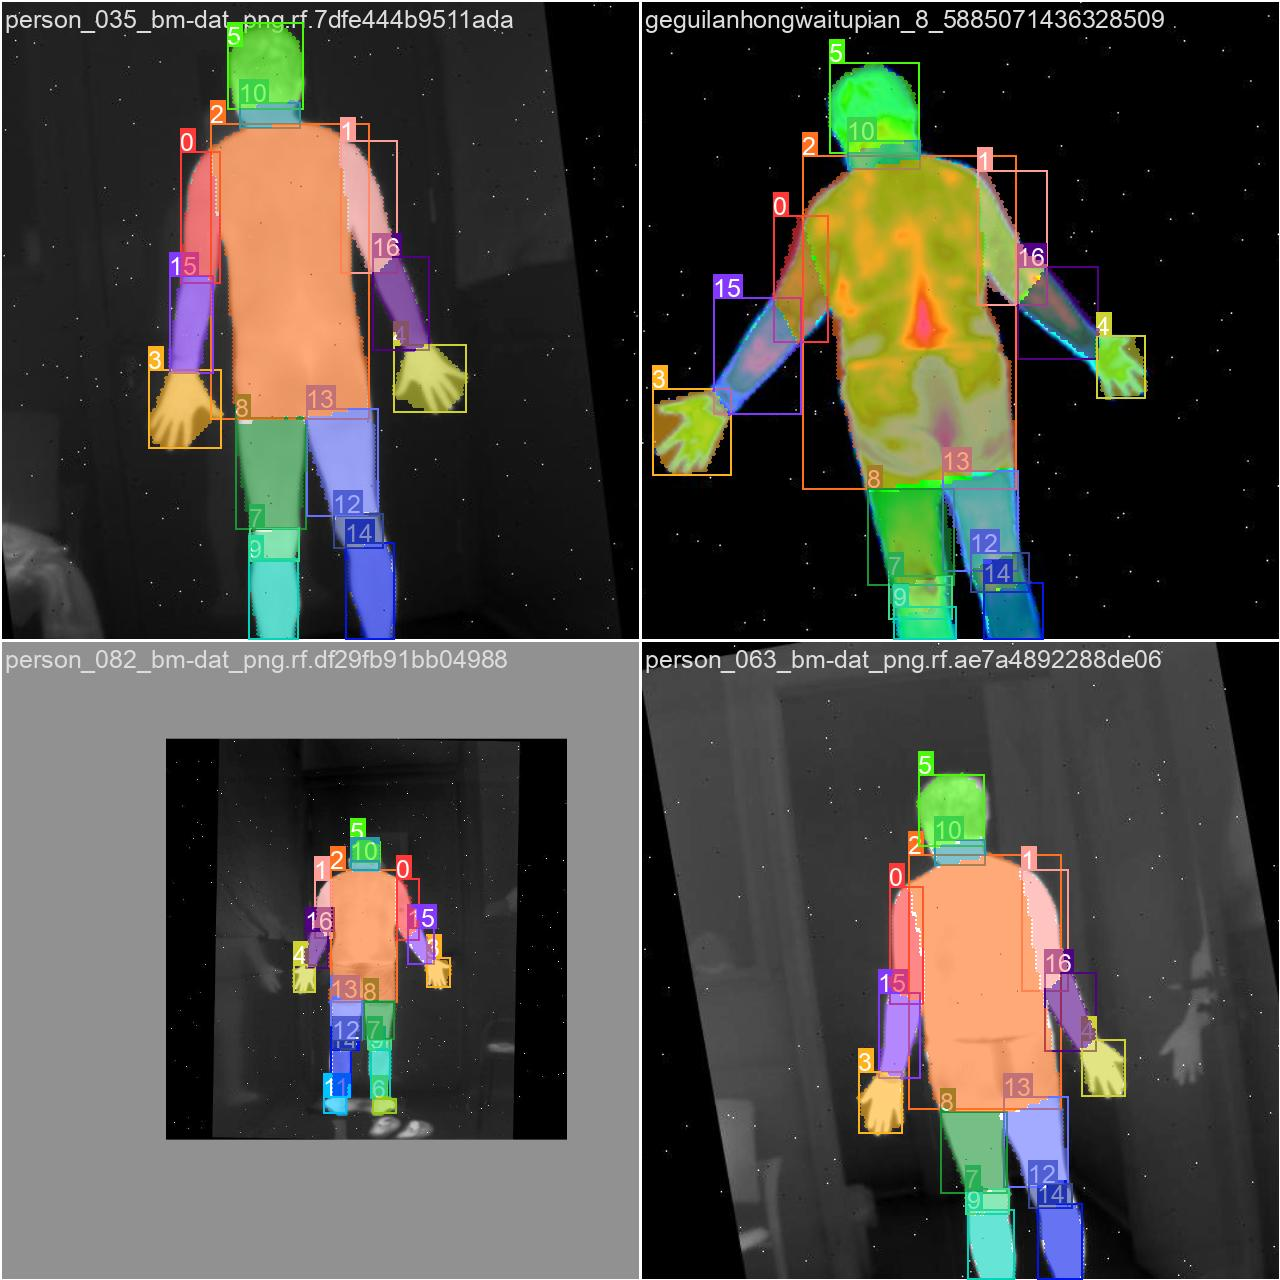

In [ ]:
Image('/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/results/100 epochs/train_batch7200.jpg')

In [ ]:
my_new_model = YOLO('/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/results/100 epochs/weights/best.pt')

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the new image
new_image = '/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/IMG_0341.jpg'

# Open an image
image = Image.open(new_image)

# Resize the image to the desired dimensions (640x640)
desired_size = (640, 640)
resized_image = image.resize(desired_size)

# Display the resized image
resized_image.show()

# Make predictions based on the resized image
new_results = my_new_model.predict(resized_image, conf=0.1) # adjustable conf threshold

# Plot the predicted results
new_result_array = new_results[0].plot()
plt.figure(figsize=(12, 12))
plt.imshow(new_result_array)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

YOLOv8 provides rapid training times, but we have observed that the model's accuracy is lower than desired. To improve performance, we plan to increase the number of training epochs. Additionally, we will experiment with training the model using Detectron2 as an alternative approach to potentially achieve better accuracy.

##b) Using Detectron 2

*Detectron2 is an Open Source object detection and segmentation framework developed by Facebook AI Research.
*It is built on top of PyTorch and provides a unified API for a variety of tasks, including object detection, instance segmentation and panoptic segmentation.
*It's designed to be flexible, easy-to-use and puts a focus on enabling rapid research.
*It includes high quality implimentations of state-of-the-art algorithms like Mask R-CNN, Retina Net and DensePose.
*It uses the following approach to object detection:
1. Uses a Region Proposal Network (RPN) to generate a set of candidate region.
2. It uses Mask R-CNN to classify and segment candidate regions.

###Installing Detectron

In [ ]:
import sys
import os
import distutils.core

# Ensure you have the latest version of pip
!python -m pip install --upgrade pip

# Install specific version of pyyaml
try:
    !python -m pip install pyyaml==5.1.2
except:
    print("Error installing pyyaml 5.1.2, trying alternative methods")
    !python -m pip install --no-cache-dir pyyaml==5.1
    !python -m pip install pyyaml==5.1 --only-binary :all:

# Clone the Detectron2 repository
!git clone 'https://github.com/facebookresearch/detectron2'

# Navigate to the Detectron2 directory
os.chdir('detectron2')

# Run the setup script to get install requirements
dist = distutils.core.run_setup("setup.py")

# Install Detectron2 dependencies
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}

# Navigate back to the original directory
os.chdir('..')

# Add Detectron2 to the Python path
sys.path.insert(0, os.path.abspath('./detectron2'))

# Verify installation
import detectron2
print("Detectron2 installed and imported successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.0/265.0 kB 5.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15681, done.
remote: Counting objects: 100% (404/404), done.
remote: Compressing objects: 100% (310/310), done.
remote: Total 15681 (delta 180), reused 2

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [ ]:
import subprocess

def check_nvidia_gpu():
  """Checks if there is an NVIDIA GPU available."""
  try:
    output = subprocess.check_output(["nvidia-smi"])
    return True
  except:
    return False

if not check_nvidia_gpu():
  raise RuntimeError("No NVIDIA GPU found. Please ensure you have an NVIDIA GPU and the appropriate drivers installed.")

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

The default models are trained on natural images so let's load a natural image and see the output

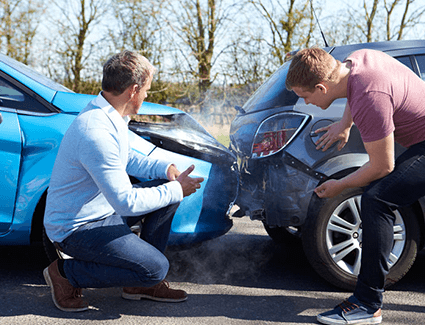

In [ ]:
im = cv2.imread('/content/drive/MyDrive/body_part_identification/detectron test image.png')

cv2_imshow(im)

We create a detectron2 config and a detectron2 DefaultPredictor to run intference on this image

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[05/23 09:45:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:02, 87.3MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0, 0, 2, 2, 2, 2, 3], device='cuda:0')
Boxes(tensor([[4.3880e+01, 4.3922e+01, 2.1203e+02, 3.1157e+02],
        [2.8330e+02, 4.7138e+01, 4.2500e+02, 3.1651e+02],
        [3.7562e-01, 5.2122e+01, 9.7926e+01, 2.5772e+02],
        [0.0000e+00, 5.7668e+01, 2.3663e+02, 2.6762e+02],
        [1.2588e+02, 1.0232e+02, 2.4228e+02, 2.4420e+02],
        [1.9376e+02, 4.9757e+01, 4.2205e+02, 2.8519e+02],
        [2.1037e+02, 7.9047e+01, 3.8854e+02, 2.9195e+02]], device='cuda:0'))


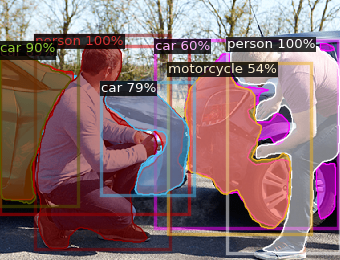

In [ ]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

Now we know that the model is working.

###Training on our custom dataset.

We will import the necessary function to register datasets in the COCO format.Let us register both the training and validation datasets. Basically a COCO dataset will have the Images and the JSON file containing the locations of the annotations done on the images. You can use such tools as CVAT, makesense.ai, the annotation tool on Microsoft Azure to annotate your images. Such tools as roboflow give one the ability to convert between JSON and COCO datasets among other datasets.

In [ ]:
from detectron2.data.datasets import register_coco_instances
#train dataset; define path to the json file in the train folder and the path to the train folder
register_coco_instances('train_dataset', {}, '/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.coco/train/_annotations.coco.json', '/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.coco/train')
#val dataset; define path to the json file in the val folder and the path to the val folder
register_coco_instances('val_dataset', {}, '/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.coco/valid/_annotations.coco.json', '/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.coco/valid')

We will proceed to extract the metadata and dataset dictionaries for both training and validation datasets. This can be used later for visualization.

In [ ]:
train_metadata = MetadataCatalog.get("train_dataset")
train_dataset_dicts = DatasetCatalog.get("train_dataset")

WARNING [05/20 08:01:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/20 08:01:47 d2.data.datasets.coco]: Loaded 318 images in COCO format from /content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.coco/train/_annotations.coco.json


In [ ]:
val_metadata = MetadataCatalog.get("val_dataset")
val_dataset_dicts = DatasetCatalog.get("val_dataset")

WARNING [05/20 08:01:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/20 08:01:55 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.coco/valid/_annotations.coco.json


Let's proceed to visualize our dataset

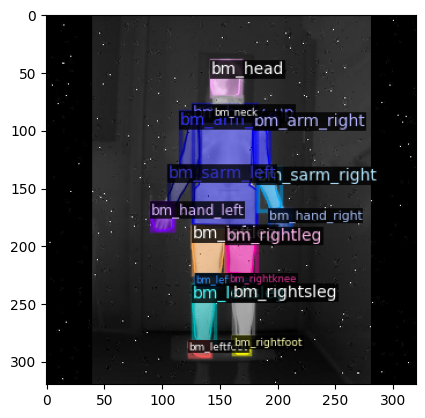

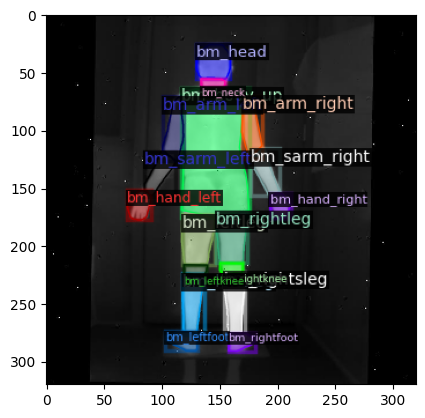

In [ ]:
from matplotlib import pyplot as plt
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

###Training our model

In [ ]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.OUTPUT_DIR = '/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.coco/detectron_model_output'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 17

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

[05/23 09:46:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:
trainer.train()

[05/17 10:20:06 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/17 10:20:38 d2.utils.events]:  eta: 1:56:31  iter: 19  total_loss: 6.399  loss_cls: 3.052  loss_box_reg: 0.3303  loss_mask: 0.6959  loss_rpn_cls: 2.112  loss_rpn_loc: 0.1778    time: 1.1061  last_time: 0.9646  data_time: 1.2112  last_data_time: 0.5364   lr: 4.9953e-06  max_mem: 2449M
[05/17 10:21:04 d2.utils.events]:  eta: 2:06:47  iter: 39  total_loss: 5.852  loss_cls: 2.891  loss_box_reg: 0.5232  loss_mask: 0.6945  loss_rpn_cls: 1.575  loss_rpn_loc: 0.1606    time: 1.2072  last_time: 0.3993  data_time: 0.9086  last_data_time: 0.0040   lr: 9.9902e-06  max_mem: 2449M
[05/17 10:21:19 d2.utils.events]:  eta: 2:15:04  iter: 59  total_loss: 4.859  loss_cls: 2.615  loss_box_reg: 0.659  loss_mask: 0.6936  loss_rpn_cls: 0.8164  loss_rpn_loc: 0.1449    time: 1.0406  last_time: 0.4517  data_time: 0.3083  last_data_time: 0.0041   lr: 1.4985e-05  max_mem: 2450M
[05/17 10:21:34 d2.utils.events]:  eta: 2:13:58  iter: 79  total_loss: 4.25  loss_cls: 2.259  loss_box_reg: 0.7918  loss_mask: 0.6931

In [ ]:
#look at training curves in tensorboard
%load_ext tensorboard
%tensorboard --logdir ''

###Inference & evaluation of our model

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/23 09:47:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.coco/detectron_model_output/model_final.pth ...


In [ ]:
import os
import yaml
#specify the path to the folder where you want to save the YAML file
output_folder = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.coco/detectron_model_output"

# # Create the folder if it doesn't exist
# os.makedirs(output_folder, exist_ok=True)

#generate the path for the YAML file within the folder
config_yaml_path = os.path.join(output_folder, "config.yaml")

#write the configuration to the YAML file
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [ ]:
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

# Load the image
image_path = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.yolov8/IMG_0341.jpg"
image = cv2.imread(image_path)

# Resize the image
desired_size = (1220, 1220)
resized_image = cv2.resize(image, desired_size)

# Specify the paths for the model files
model_weights_path = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.coco/detectron_model_output/model_final.pth"
config_file_path = "/content/drive/MyDrive/body_part_identification/person_part_seg_bm.v5i.coco/detectron_model_output/config.yaml"

# Load the model configuration
cfg = get_cfg()
cfg.merge_from_file(config_file_path)
cfg.MODEL.WEIGHTS = model_weights_path

# Create a predictor
predictor = DefaultPredictor(cfg)

# Run the predictor
outputs = predictor(resized_image)

# Extract the predicted class indices
pred_classes = outputs["instances"].pred_classes

# Get the metadata for the dataset
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

# Map the class indices to their corresponding names
detected_parts = [metadata.thing_classes[i] for i in pred_classes]

# Print the names of the detected parts
print("Detected parts:", detected_parts)

# Use Visualizer to draw the predictions on the image
v = Visualizer(resized_image[:, :, ::-1], metadata=metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Get the output image with predictions
output_image = out.get_image()[:, :, ::-1]

# Display the output image with predictions
plt.figure(figsize=(20, 18))
plt.imshow(output_image)
plt.axis('off')  # Hide axes
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Detectron2 offered a better output compared to YOLOv8. With more data, the model can perform better